## Problem Statement

You need to build a model that is able to classify customer complaints based on the products/services. By doing so, you can segregate these tickets into their relevant categories and, therefore, help in the quick resolution of the issue.

You will be doing topic modelling on the <b>.json</b> data provided by the company. Since this data is not labelled, you need to apply NMF to analyse patterns and classify tickets into the following five clusters based on their products/services:

* Credit card / Prepaid card

* Bank account services

* Theft/Dispute reporting

* Mortgages/loans

* Others


With the help of topic modelling, you will be able to map each ticket onto its respective department/category. You can then use this data to train any supervised model such as logistic regression, decision tree or random forest. Using this trained model, you can classify any new customer complaint support ticket into its relevant department.

## Pipelines that needs to be performed:

You need to perform the following eight major tasks to complete the assignment:

1.  Data loading

2. Text preprocessing

3. Exploratory data analysis (EDA)

4. Feature extraction

5. Topic modelling

6. Model building using supervised learning

7. Model training and evaluation

8. Model inference

## Importing the necessary libraries

In [1]:
import json
import numpy as np
import pandas as pd
import re, nltk, spacy, string
import en_core_web_sm
nlp = en_core_web_sm.load()
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from plotly.offline import plot
import plotly.graph_objects as go
import plotly.express as px

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from pprint import pprint

## Loading the data

The data is in JSON format and we need to convert it to a dataframe.

In [2]:
# Opening JSON file
f = open("./complaints-2021-05-14_08_16.json")# Write the path to your data file and load it

# returns JSON object as
# a dictionary
data = json.load(f)
df=pd.json_normalize(data)

## Data preparation

In [3]:
# Inspect the dataframe to understand the given data.

df.head()

,_index,_type,_id,_score,_source.tags,_source.zip_code,_source.complaint_id,_source.issue,_source.date_received,_source.state,...,_source.company_response,_source.company,_source.submitted_via,_source.date_sent_to_company,_source.company_public_response,_source.sub_product,_source.timely,_source.complaint_what_happened,_source.sub_issue,_source.consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided
3,complaint-public-v2,complaint,2673060,0.0,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,Consent not provided
4,complaint-public-v2,complaint,3203545,0.0,None,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,...,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,,Charged too much interest,N/A


In [4]:
#print the column names
df.columns

Index(['_index', '_type', '_id', '_score', '_source.tags', '_source.zip_code',
       '_source.complaint_id', '_source.issue', '_source.date_received',
       '_source.state', '_source.consumer_disputed', '_source.product',
       '_source.company_response', '_source.company', '_source.submitted_via',
       '_source.date_sent_to_company', '_source.company_public_response',
       '_source.sub_product', '_source.timely',
       '_source.complaint_what_happened', '_source.sub_issue',
       '_source.consumer_consent_provided'],
      dtype='object')

In [5]:
#Assign new column names
df.columns = [
    'index', 'type', 'id', 'score', 'tags', 'zip_code',
    'complaint_id', 'issue', 'date_received', 'state',
    'consumer_disputed', 'product', 'company_response', 'company',
    'submitted_via', 'date_sent_to_company', 'company_public_response',
    'sub_product', 'timely', 'complaint_what_happened', 'sub_issue',
    'consumer_consent_provided'
]

In [6]:
#Assign nan in place of blanks in the complaints column
df['complaints'] = df['complaint_what_happened'].replace(r'^\s*$', np.nan, regex=True)

In [7]:
#Remove all rows where complaints column is nan
df = df.dropna(subset=['complaints'])

## Prepare the text for topic modeling

Once you have removed all the blank complaints, you need to:

* Make the text lowercase
* Remove text in square brackets
* Remove punctuation
* Remove words containing numbers


Once you have done these cleaning operations you need to perform the following:
* Lemmatize the texts
* Extract the POS tags of the lemmatized text and remove all the words which have tags other than NN[tag == "NN"].


In [8]:
# Write your function here to clean the text and remove all the unnecessary elements.
import re
import string

def clean_text(text):
    # Convert to lowercase
    text = text.lower()
    # Remove text in square brackets
    text = re.sub(r'\[.*?\]', '', text)
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Remove words containing numbers
    text = re.sub(r'\w*\d\w*', '', text)
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# Apply the cleaning function to the complaints column
df['complaints'] = df['complaints'].apply(clean_text)

In [9]:
#Write your function to Lemmatize the texts
def lemmatize_text(text):
    doc = nlp(text)
    lemmas = [token.lemma_ for token in doc]
    return ' '.join(lemmas)

# Create a new column with lemmatized text
df['lemmatized_complaints'] = df['complaints'].apply(lemmatize_text)

In [10]:
#Create a dataframe('df_clean') that will have only the complaints and the lemmatized complaints
df_clean = df[["complaints", "lemmatized_complaints"]]

In [11]:
df_clean.head()

,complaints,lemmatized_complaints
1,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and I apprec...
2,i upgraded my xxxx xxxx card in and was told b...,I upgrade my xxxx xxxx card in and be tell by ...
10,chase card was reported on however fraudulent ...,chase card be report on however fraudulent app...
11,on while trying to book a xxxx xxxx ticket i c...,on while try to book a xxxx xxxx ticket I come...
14,my grand son give me check for i deposit it in...,my grand son give I check for I deposit it int...


In [12]:
#Write your function to extract the POS tags

def pos_tag(text):
  # write your code here
    doc = nlp(text)
    # Keep only words with POS tag == "NN"
    nouns = [token.text for token in doc if token.tag_ == "NN"]
    return ' '.join(nouns)
    
df_clean["complaint_POS_removed"] =  df_clean['lemmatized_complaints'].apply(pos_tag) #this column should contain lemmatized text with all the words removed which have tags other than NN[tag == "NN"].

/tmp/ipykernel_568182/1692088628.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [14]:
#The clean dataframe should now contain the raw complaint, lemmatized complaint and the complaint after removing POS tags.
df_clean.head()

,complaints,lemmatized_complaints,complaint_POS_removed
1,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and I apprec...,morning name stop service debt verification st...
2,i upgraded my xxxx xxxx card in and was told b...,I upgrade my xxxx xxxx card in and be tell by ...,card agent anniversary date agent information ...
10,chase card was reported on however fraudulent ...,chase card be report on however fraudulent app...,chase card report application identity consent...
11,on while trying to book a xxxx xxxx ticket i c...,on while try to book a xxxx xxxx ticket I come...,ticket offer ticket reward card information of...
14,my grand son give me check for i deposit it in...,my grand son give I check for I deposit it int...,son chase account fund chase bank account mone...


## Exploratory data analysis to get familiar with the data.

Write the code in this task to perform the following:

*   Visualise the data according to the 'Complaint' character length
*   Using a word cloud find the top 40 words by frequency among all the articles after processing the text
*   Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text. ‘




/tmp/ipykernel_568182/2056527774.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



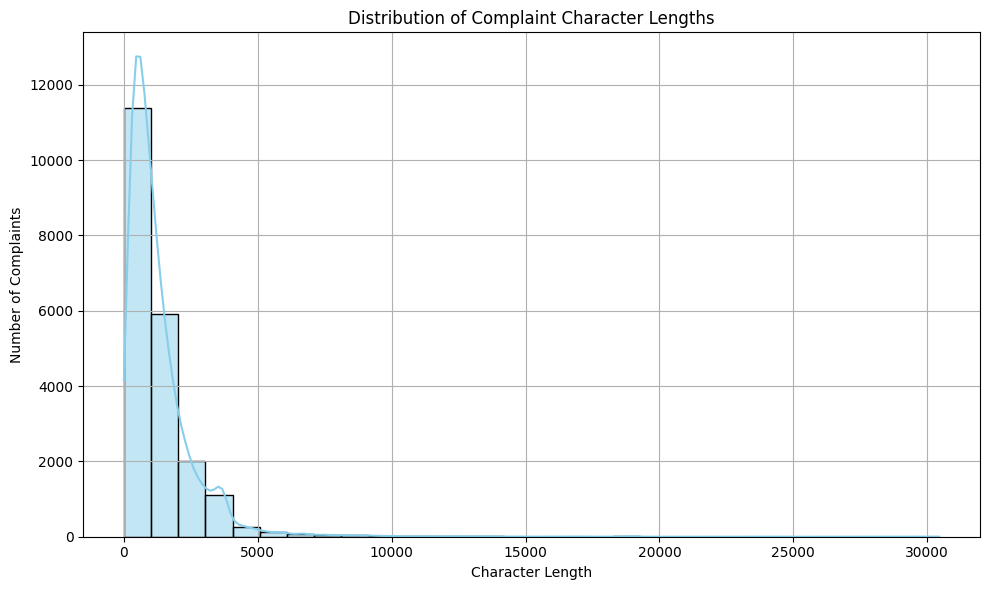

In [17]:
# Write your code here to visualise the data according to the 'Complaint' character length
df_clean['complaint_length'] = df_clean['complaints'].apply(len)

# Set plot style
plt.figure(figsize=(10, 6))
sns.histplot(df_clean['complaint_length'], bins=30, kde=True, color='skyblue')

# Customize plot
plt.title('Distribution of Complaint Character Lengths')
plt.xlabel('Character Length')
plt.ylabel('Number of Complaints')
plt.grid(True)
plt.tight_layout()

# Show plot
plt.show()

#### Find the top 40 words by frequency among all the articles after processing the text.

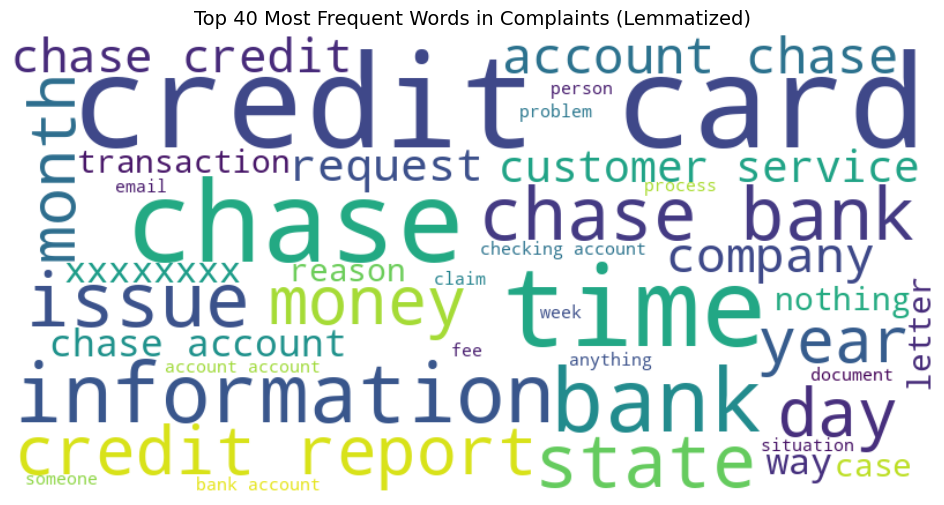

In [18]:
#Using a word cloud find the top 40 words by frequency among all the articles after processing the text
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Combine all lemmatized complaints into one large text
all_words = ' '.join(df_clean['complaint_POS_removed'])

# Generate the word cloud
wordcloud = WordCloud(
    width=800,
    height=400,
    background_color='white',
    max_words=40,
    colormap='viridis'
).generate(all_words)

# Display the word cloud
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Top 40 Most Frequent Words in Complaints (Lemmatized)', fontsize=14)
plt.show()

In [19]:
#Removing -PRON- from the text corpus
df_clean['Complaint_clean'] = df_clean['complaint_POS_removed'].str.replace('-PRON-', '')

/tmp/ipykernel_568182/3655474111.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



#### Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text.

/tmp/ipykernel_568182/4274075215.py:21: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




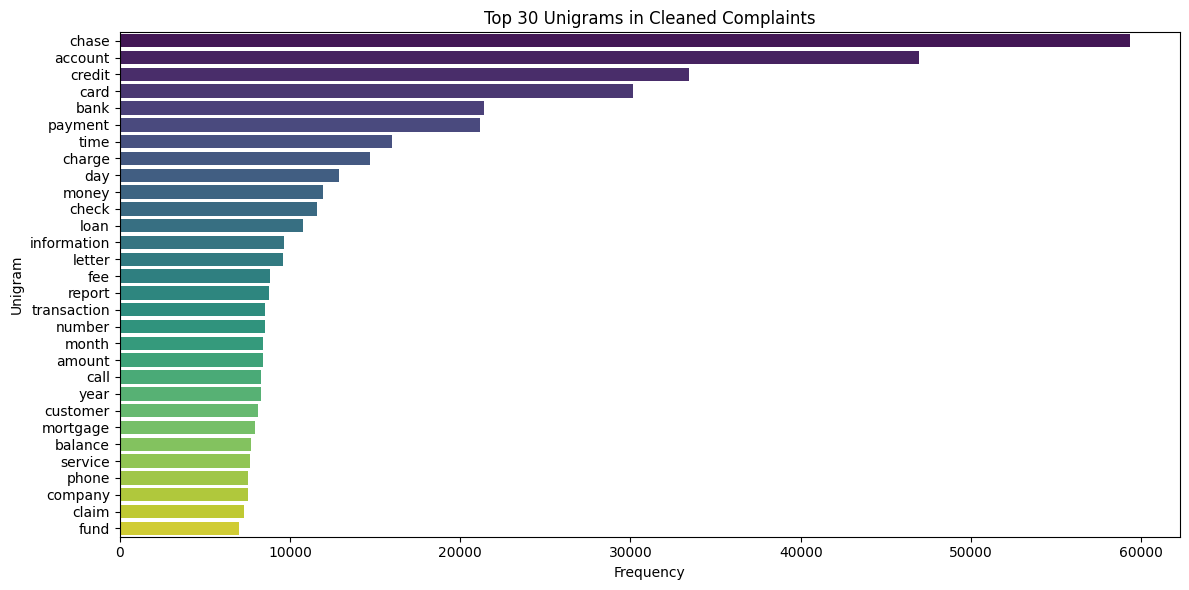

In [20]:
#Write your code here to find the top 30 unigram frequency among the complaints in the cleaned datafram(df_clean).
from collections import Counter
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Split all the words in the 'Complaint_clean' column
all_words = ' '.join(df_clean['Complaint_clean']).split()

# Count unigram frequencies
word_freq = Counter(all_words)

# Get the top 30 most common words
top_30_unigrams = word_freq.most_common(30)

# Convert to DataFrame for plotting
unigram_df = pd.DataFrame(top_30_unigrams, columns=['Word', 'Frequency'])

# Plotting
plt.figure(figsize=(12, 6))
sns.barplot(data=unigram_df, x='Frequency', y='Word', palette='viridis')
plt.title('Top 30 Unigrams in Cleaned Complaints')
plt.xlabel('Frequency')
plt.ylabel('Unigram')
plt.tight_layout()
plt.show()

In [21]:
#Print the top 10 words in the unigram frequency
top_10_unigrams = word_freq.most_common(10)

# Print them
print("Top 10 Unigrams:")
for word, freq in top_10_unigrams:
    print(f"{word}: {freq}")

Top 10 Unigrams:
chase: 59310
account: 46967
credit: 33457
card: 30143
bank: 21390
payment: 21139
time: 15978
charge: 14715
day: 12904
money: 11921


/tmp/ipykernel_568182/1746633620.py:27: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




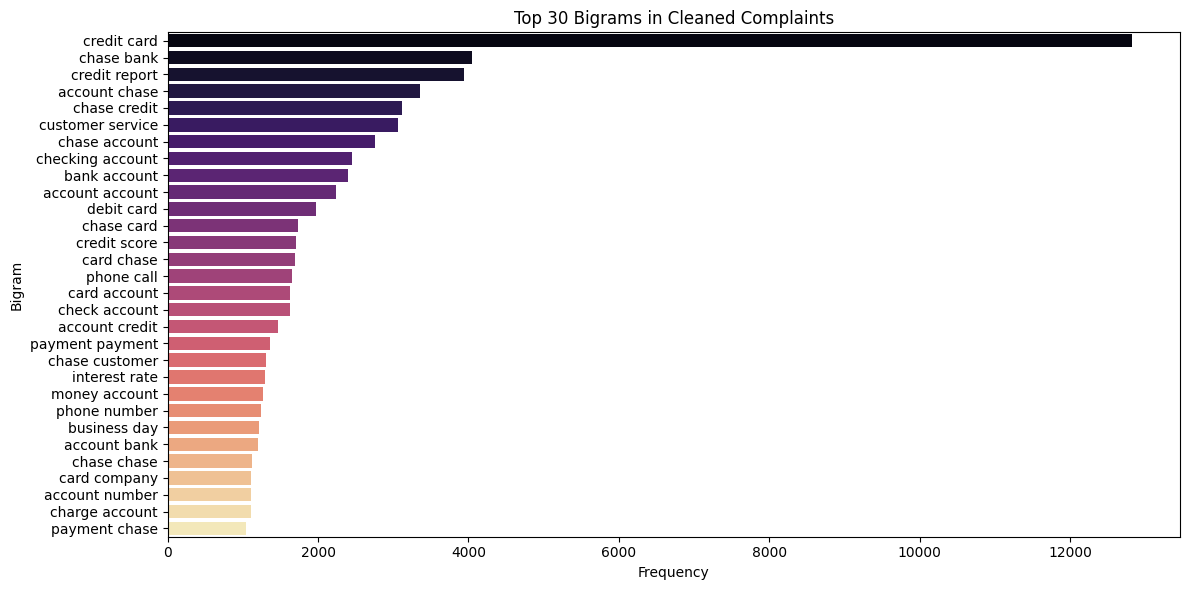

In [22]:
#Write your code here to find the top 30 bigram frequency among the complaints in the cleaned datafram(df_clean).
from nltk import bigrams
from collections import Counter
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Create a list of all bigrams from the complaint text
all_bigrams = []

for text in df_clean['Complaint_clean']:
    tokens = text.split()
    all_bigrams.extend(list(bigrams(tokens)))

# Count bigram frequencies
bigram_freq = Counter(all_bigrams)

# Get the top 30 most common bigrams
top_30_bigrams = bigram_freq.most_common(30)

# Convert to DataFrame for visualization
bigram_df = pd.DataFrame(top_30_bigrams, columns=['Bigram', 'Frequency'])
bigram_df['Bigram'] = bigram_df['Bigram'].apply(lambda x: ' '.join(x))  # convert tuple to string

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(data=bigram_df, x='Frequency', y='Bigram', palette='magma')
plt.title('Top 30 Bigrams in Cleaned Complaints')
plt.xlabel('Frequency')
plt.ylabel('Bigram')
plt.tight_layout()
plt.show()

In [ ]:
#Print the top 10 words in the bigram frequency
top_10_bigrams = bigram_freq.most_common(10)

# Print them
print("Top 10 Bigrams:")
for word, freq in top_10_bigrams:
    print(f"{word}: {freq}")

/tmp/ipykernel_568182/3395286118.py:27: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




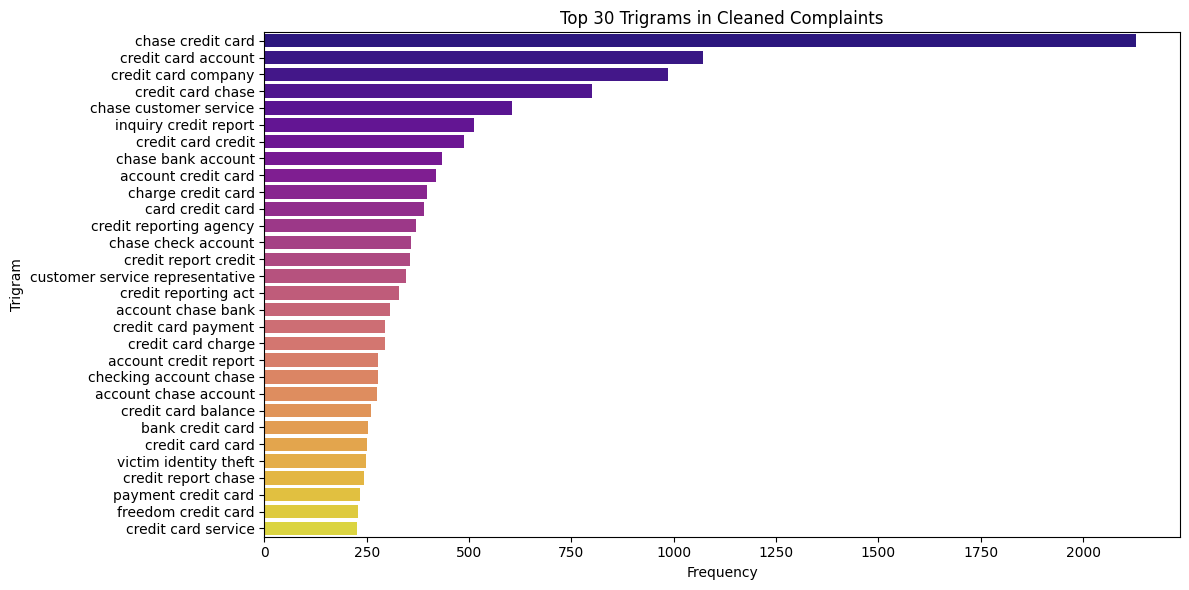

In [24]:
#Write your code here to find the top 30 trigram frequency among the complaints in the cleaned datafram(df_clean).
from nltk import trigrams
from collections import Counter
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Create a list of all trigrams from the complaint text
all_trigrams = []

for text in df_clean['Complaint_clean']:
    tokens = text.split()
    all_trigrams.extend(list(trigrams(tokens)))

# Count trigram frequencies
trigram_freq = Counter(all_trigrams)

# Get the top 30 most common trigrams
top_30_trigrams = trigram_freq.most_common(30)

# Convert to DataFrame for visualization
trigram_df = pd.DataFrame(top_30_trigrams, columns=['Trigram', 'Frequency'])
trigram_df['Trigram'] = trigram_df['Trigram'].apply(lambda x: ' '.join(x))  # convert tuple to string

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(data=trigram_df, x='Frequency', y='Trigram', palette='plasma')
plt.title('Top 30 Trigrams in Cleaned Complaints')
plt.xlabel('Frequency')
plt.ylabel('Trigram')
plt.tight_layout()
plt.show()

In [25]:
#Print the top 10 words in the trigram frequency
top_10_trigrams = trigram_freq.most_common(10)

# Print them
print("Top 10 Trigrams:")
for word, freq in top_10_trigrams:
    print(f"{word}: {freq}")

Top 10 Trigrams:
('chase', 'credit', 'card'): 2130
('credit', 'card', 'account'): 1071
('credit', 'card', 'company'): 987
('credit', 'card', 'chase'): 800
('chase', 'customer', 'service'): 606
('inquiry', 'credit', 'report'): 512
('credit', 'card', 'credit'): 488
('chase', 'bank', 'account'): 435
('account', 'credit', 'card'): 419
('charge', 'credit', 'card'): 398


## The personal details of customer has been masked in the dataset with xxxx. Let's remove the masked text as this will be of no use for our analysis

In [26]:
df_clean['Complaint_clean'] = df_clean['Complaint_clean'].str.replace('xxxx','')

/tmp/ipykernel_568182/619742717.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [30]:
#All masked texts has been removed
df_clean.head()

,complaints,lemmatized_complaints,complaint_POS_removed,complaint_length,Complaint_clean
1,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and I apprec...,morning name stop service debt verification st...,469,morning name stop service debt verification st...
2,i upgraded my xxxx xxxx card in and was told b...,I upgrade my xxxx xxxx card in and be tell by ...,card agent anniversary date agent information ...,334,card agent anniversary date agent information ...
10,chase card was reported on however fraudulent ...,chase card be report on however fraudulent app...,chase card report application identity consent...,209,chase card report application identity consent...
11,on while trying to book a xxxx xxxx ticket i c...,on while try to book a xxxx xxxx ticket I come...,ticket offer ticket reward card information of...,1424,ticket offer ticket reward card information of...
14,my grand son give me check for i deposit it in...,my grand son give I check for I deposit it int...,son chase account fund chase bank account mone...,452,son chase account fund chase bank account mone...


## Feature Extraction
Convert the raw texts to a matrix of TF-IDF features

**max_df** is used for removing terms that appear too frequently, also known as "corpus-specific stop words"
max_df = 0.95 means "ignore terms that appear in more than 95% of the complaints"

**min_df** is used for removing terms that appear too infrequently
min_df = 2 means "ignore terms that appear in less than 2 complaints"

In [31]:
#Write your code here to initialise the TfidfVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize TF-IDF Vectorizer with filtering thresholds
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2)

#### Create a document term matrix using fit_transform

The contents of a document term matrix are tuples of (complaint_id,token_id) tf-idf score:
The tuples that are not there have a tf-idf score of 0

In [32]:
#Write your code here to create the Document Term Matrix by transforming the complaints column present in df_clean.
dtm = tfidf_vectorizer.fit_transform(df_clean['Complaint_clean'])

## Topic Modelling using NMF

Non-Negative Matrix Factorization (NMF) is an unsupervised technique so there are no labeling of topics that the model will be trained on. The way it works is that, NMF decomposes (or factorizes) high-dimensional vectors into a lower-dimensional representation. These lower-dimensional vectors are non-negative which also means their coefficients are non-negative.

In this task you have to perform the following:

* Find the best number of clusters
* Apply the best number to create word clusters
* Inspect & validate the correction of each cluster wrt the complaints
* Correct the labels if needed
* Map the clusters to topics/cluster names

In [33]:
from sklearn.decomposition import NMF
pd.DataFrame(dtm.toarray(), columns=tfidf_vectorizer.get_feature_names_out())

,aa,aarp,abandonment,abatement,abbreviation,abet,abide,ability,above,abovementione,...,you,youinv,youth,yr,yrs,zap,zip,zipcode,zombie,zone
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21067,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
21068,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
21069,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
21070,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.147748,0.0,0.0,0.0,0.0,0.0


## Manual Topic Modeling
You need to do take the trial & error approach to find the best num of topics for your NMF model.

The only parameter that is required is the number of components i.e. the number of topics we want. This is the most crucial step in the whole topic modeling process and will greatly affect how good your final topics are.

In [34]:
#Load your nmf_model with the n_components i.e 5
num_topics = 10 #write the value you want to test out

#keep the random_state =40
nmf =  NMF(n_components=num_topics)#write your code here

In [35]:
w = nmf.fit_transform(dtm)
h = nmf.components_

In [36]:
#Print the Top15 words for each of the topics
words = tfidf_vectorizer.get_feature_names_out()
topic_words = pd.DataFrame(
    np.zeros((num_topics, 15), dtype=object), 
    index=[f"Topic {i+1}" for i in range(num_topics)], 
    columns=[f"Word {i+1}" for i in range(15)]
)

# Fill the DataFrame with top words for each topic
for topic_idx, topic in enumerate(nmf.components_):
    top_indices = topic.argsort()[-15:][::-1]
    top_terms = [words[i] for i in top_indices]
    topic_words.iloc[topic_idx] = top_terms

# Display the DataFrame
topic_words


,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14,Word 15
Topic 1,account,checking,chase,reason,bank,deposit,branch,business,fund,access,year,balance,letter,information,activity
Topic 2,card,credit,chase,score,limit,point,year,application,service,time,offer,company,customer,reward,reason
Topic 3,payment,month,day,time,chase,credit,auto,statement,amount,bill,mortgage,date,error,car,report
Topic 4,charge,dispute,merchant,chase,amount,fraud,company,purchase,statement,refund,item,letter,service,transaction,billing
Topic 5,loan,mortgage,home,chase,modification,property,year,foreclosure,letter,document,house,sale,time,request,rate
Topic 6,report,inquiry,credit,company,reporting,information,debt,identity,score,theft,bureau,inquire,bureaus,date,file
Topic 7,check,deposit,fund,bank,cash,day,money,branch,chase,hold,amount,business,cashier,teller,mail
Topic 8,fee,overdraft,transaction,charge,year,fund,bank,dollar,time,customer,day,bill,month,service,deposit
Topic 9,money,bank,transaction,chase,claim,number,phone,day,fraud,call,email,transfer,time,fund,information
Topic 10,balance,interest,rate,statement,transfer,amount,purchase,month,date,apr,period,advance,credit,offer,billing


In [37]:
#Create the best topic for each complaint in terms of integer value 0,1,2,3 & 4
W = pd.DataFrame(w, columns=[f"Topic {i+1}" for i in range(num_topics)])
W["best_topic"] = W.idxmax(axis=1)
W["best_topic"] = W["best_topic"].apply(lambda x: int(x.split()[1]) - 1)
W.head()

,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9,Topic 10,best_topic
0,0.016914,0.002710,0.005654,0.002357,0.015782,0.010114,0.003073,0.002789,0.018310,0.013972,8
1,0.009808,0.014672,0.001214,0.002898,0.003047,0.000315,0.000000,0.000909,0.004284,0.001268,1
2,0.003374,0.036487,0.000000,0.000000,0.002691,0.033006,0.000000,0.000253,0.002473,0.000000,1
3,0.020619,0.036037,0.001214,0.000188,0.014982,0.030779,0.000000,0.000281,0.019834,0.001886,1
4,0.021242,0.002948,0.000000,0.000000,0.003766,0.000000,0.079690,0.000000,0.056953,0.000000,6


In [50]:
#Assign the best topic to each of the cmplaints in Topic Column

df_clean['Topic'] = W["best_topic"].astype(int) #write your code to assign topics to each rows.

/tmp/ipykernel_568182/1846642556.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [40]:
df_clean.head()

,complaints,lemmatized_complaints,complaint_POS_removed,complaint_length,Complaint_clean,Topic
1,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and I apprec...,morning name stop service debt verification st...,469,morning name stop service debt verification st...,1.0
2,i upgraded my xxxx xxxx card in and was told b...,I upgrade my xxxx xxxx card in and be tell by ...,card agent anniversary date agent information ...,334,card agent anniversary date agent information ...,1.0
10,chase card was reported on however fraudulent ...,chase card be report on however fraudulent app...,chase card report application identity consent...,209,chase card report application identity consent...,0.0
11,on while trying to book a xxxx xxxx ticket i c...,on while try to book a xxxx xxxx ticket I come...,ticket offer ticket reward card information of...,1424,ticket offer ticket reward card information of...,5.0
14,my grand son give me check for i deposit it in...,my grand son give I check for I deposit it int...,son chase account fund chase bank account mone...,452,son chase account fund chase bank account mone...,1.0


In [51]:
#Print the first 5 Complaint for each of the Topics
pd.set_option('display.max_colwidth', None)
df_cleaned=df_clean.groupby('Topic').head(5)
#df_cleaned.sort_values('Topic')
df_cleaned[['Topic', 'complaints']].sort_values('Topic')

Topic  \
10     0.0   
15     0.0   
94     0.0   
58     0.0   
101    0.0   
14     1.0   
2      1.0   
21     1.0   
27     1.0   
1      1.0   
57     2.0   
73     2.0   
111    2.0   
143    2.0   
93     2.0   
43     3.0   
95     3.0   
26     3.0   
172    3.0   
128    3.0   
23     4.0   
35     4.0   
32     4.0   
30     4.0   
131    4.0   
154    5.0   
59     5.0   
11     5.0   
63     5.0   
42     5.0   
52     6.0   
78     6.0   
156    6.0   
127    6.0   
65     6.0   
150    7.0   
221    7.0   
223    7.0   
86     7.0   
153    7.0   
20     8.0   
64     8.0   
50     8.0   
45     8.0   
17     8.0   
24     9.0   
349    9.0   
357    9.0   
389    9.0   
434    9.0   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

In [52]:
#Print the first 5 Complaint for each of the Topics
df_clean.shape

(21072, 6)

#### After evaluating the mapping, if the topics assigned are correct then assign these names to the relevant topic:
* Bank Account services
* Credit card or prepaid card
* Theft/Dispute Reporting
* Mortgage/Loan
* Others

In [57]:
#Create the dictionary of Topic names and Topics


Topic_names = {
    "0.0": "Theft/Dispute Reporting",
    "1.0": "Bank Account services",
    "2.0": "Mortgage/Loan",
    "3.0": "Credit card or prepaid card",
    "4.0": "Bank Account services",
    "5.0": "Bank Account services",
    "6.0": "Theft/Dispute Reporting",
    "7.0": "Others",
    "8.0": "Others",
    "9.0": "Bank Account services"
}
#Replace Topics with Topic Names
pd.reset_option('display.max_colwidth')
df_clean['Topic'] = df_clean['Topic'].astype(str)
df_clean['Topic_name'] = df_clean['Topic'].map(Topic_names)

/tmp/ipykernel_568182/2742163768.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_568182/2742163768.py:19: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [56]:
df_clean.head()

,complaints,lemmatized_complaints,complaint_POS_removed,complaint_length,Complaint_clean,Topic,Topic_name
1,good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember services in i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt i have a right to know this information as a consumer chase account xxxx xxxx xxxx xxxx thanks in advance for your help,good morning my name be xxxx xxxx and I appreciate it if you could help I put a stop to chase bank cardmember service in I write to chase ask for debt verification and what they send I a statement which be not acceptable I be ask the bank to validate the debt instead I been receive mail every month from they attempt to collect a debt I have a right to know this information as a consumer chase account xxxx xxxx xxxx xxxx thank in advance for your help,morning name stop service debt verification statement bank debt mail month debt right information consumer chase account advance help,469,morning name stop service debt verification statement bank debt mail month debt right information consumer chase account advance help,1.0,Bank Account services
2,i upgraded my xxxx xxxx card in and was told by the agent who did the upgrade my anniversary date would not change it turned the agent was giving me the wrong information in order to upgrade the account xxxx changed my anniversary date from xxxxxxxx to xxxxxxxx without my consent xxxx has the recording of the agent who was misled me,I upgrade my xxxx xxxx card in and be tell by the agent who do the upgrade my anniversary date would not change it turn the agent be give I the wrong information in order to upgrade the account xxxx change my anniversary date from xxxxxxxx to xxxxxxxx without my consent xxxx have the recording of the agent who be mislead I,card agent anniversary date agent information order account anniversary date consent recording agent mislead,334,card agent anniversary date agent information order account anniversary date consent recording agent mislead,1.0,Bank Account services
10,chase card was reported on however fraudulent application have been submitted my identity without my consent to fraudulently obtain services do not extend credit without verifying the identity of the applicant,chase card be report on however fraudulent application have be submit my identity without my consent to fraudulently obtain service do not extend credit without verify the identity of the applicant,chase card report application identity consent service credit identity applicant,209,chase card report application identity consent service credit identity applicant,0.0,Theft/Dispute Reporting
11,on while trying to book a xxxx xxxx ticket i came across an offer for to be applied towards the ticket if i applied for a rewards card i put in my information for the offer and within less than a minute was notified via the screen that a decision could not be made i immediately contacted xxxx and was referred to chase bank i then immediately contacted chase bank within no more than of getting the notification on the screen and i was told by the chase representative i spoke with that my application was denied but she could not state why i asked for more information about the xxxx offer and she explained that even if i had been approved the credit offer only gets applied after the first account statement and could not be used to purchase the ticket i then explicitly told her i was glad i got denied and i was absolutely no longer interested in the account i asked that the application be withdrawn and the representative obliged this all happened no later than after putting in the application on notwithstanding my explicit request not to proceed with the application and contrary to what i was told by the chase representative chase did in 

## Supervised model to predict any new complaints to the relevant Topics.

You have now build the model to create the topics for each complaints.Now in the below section you will use them to classify any new complaints.

Since you will be using supervised learning technique we have to convert the topic names to numbers(numpy arrays only understand numbers)

In [ ]:
#Create the dictionary again of Topic names and Topics
# This step is not required

#Topic_names = {   }
#Replace Topics with Topic Names
#df_clean['Topic'] = df_clean['Topic'].map(Topic_names)

In [58]:
df_clean.head()

,complaints,lemmatized_complaints,complaint_POS_removed,complaint_length,Complaint_clean,Topic,Topic_name
1,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and I apprec...,morning name stop service debt verification st...,469,morning name stop service debt verification st...,1.0,Bank Account services
2,i upgraded my xxxx xxxx card in and was told b...,I upgrade my xxxx xxxx card in and be tell by ...,card agent anniversary date agent information ...,334,card agent anniversary date agent information ...,1.0,Bank Account services
10,chase card was reported on however fraudulent ...,chase card be report on however fraudulent app...,chase card report application identity consent...,209,chase card report application identity consent...,0.0,Theft/Dispute Reporting
11,on while trying to book a xxxx xxxx ticket i c...,on while try to book a xxxx xxxx ticket I come...,ticket offer ticket reward card information of...,1424,ticket offer ticket reward card information of...,5.0,Bank Account services
14,my grand son give me check for i deposit it in...,my grand son give I check for I deposit it int...,son chase account fund chase bank account mone...,452,son chase account fund chase bank account mone...,1.0,Bank Account services


In [59]:
#Keep the columns"complaint_what_happened" & "Topic" only in the new dataframe --> training_data
training_data=training_data = df_clean[["complaints", "Topic"]].copy()

In [60]:
training_data.head()

,complaints,Topic
1,good morning my name is xxxx xxxx and i apprec...,1.0
2,i upgraded my xxxx xxxx card in and was told b...,1.0
10,chase card was reported on however fraudulent ...,0.0
11,on while trying to book a xxxx xxxx ticket i c...,5.0
14,my grand son give me check for i deposit it in...,1.0


####Apply the supervised models on the training data created. In this process, you have to do the following:
* Create the vector counts using Count Vectoriser
* Transform the word vecotr to tf-idf
* Create the train & test data using the train_test_split on the tf-idf & topics


In [75]:

#Write your code to get the Vector count
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.model_selection import train_test_split
count_vect = CountVectorizer()
X_counts = count_vect.fit_transform(training_data['complaints'])

#Write your code here to transform the word vector to tf-idf
tfidf_transformer = TfidfTransformer()
X_tfidf = tfidf_transformer.fit_transform(X_counts)
X_train, X_test, y_train, y_test = train_test_split(
    X_tfidf, 
    training_data['Topic'], 
    test_size=0.2, 
    random_state=42
)

You have to try atleast 3 models on the train & test data from these options:
* Logistic regression
* Decision Tree
* Random Forest
* Naive Bayes (optional)

**Using the required evaluation metrics judge the tried models and select the ones performing the best**

In [76]:
# Write your code here to build any 3 models and evaluate them using the required metrics

from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report

model = MultinomialNB()
model.fit(X_train, y_train)

# Predict on test data
y_pred = model.predict(X_test)

# Evaluate
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.662870699881376
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       130
         1.0       0.00      0.00      0.00       240
         2.0       0.00      0.00      0.00       134
         3.0       0.00      0.00      0.00       125
         4.0       0.00      0.00      0.00       212
         5.0       0.00      0.00      0.00       110
         6.0       0.00      0.00      0.00       109
         7.0       0.00      0.00      0.00        50
         8.0       0.00      0.00      0.00       245
         9.0       0.00      0.00      0.00        65
         nan       0.66      1.00      0.80      2795

    accuracy                           0.66      4215
   macro avg       0.06      0.09      0.07      4215
weighted avg       0.44      0.66      0.53      4215



/home/linarc/.pyenv/versions/3.9.1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/linarc/.pyenv/versions/3.9.1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/linarc/.pyenv/versions/3.9.1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



In [81]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
# Initialize Logistic Regression model
logreg_model = LogisticRegression(max_iter=1000, random_state=42)

# Train the model
logreg_model.fit(X_train, y_train)

# Predict the topic labels on the test set
y_pred_logreg = logreg_model.predict(X_test)

# Evaluate model performance
print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred_logreg))
print("Classification Report:\n", classification_report(y_test, y_pred_logreg))

Logistic Regression Accuracy: 0.6631079478054567
Classification Report:
               precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       130
         1.0       0.00      0.00      0.00       240
         2.0       0.00      0.00      0.00       134
         3.0       0.00      0.00      0.00       125
         4.0       0.00      0.00      0.00       212
         5.0       0.00      0.00      0.00       110
         6.0       0.00      0.00      0.00       109
         7.0       0.00      0.00      0.00        50
         8.0       0.00      0.00      0.00       245
         9.0       0.00      0.00      0.00        65
         nan       0.66      1.00      0.80      2795

    accuracy                           0.66      4215
   macro avg       0.06      0.09      0.07      4215
weighted avg       0.44      0.66      0.53      4215



/home/linarc/.pyenv/versions/3.9.1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/linarc/.pyenv/versions/3.9.1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/linarc/.pyenv/versions/3.9.1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



In [82]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
# Create and train the Decision Tree model
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train, y_train)
# Predict the topics for the test data
y_pred_dt = dt_model.predict(X_test)
# Evaluate performance
print("Decision Tree Accuracy:", accuracy_score(y_test, y_pred_dt))
print("Classification Report:\n", classification_report(y_test, y_pred_dt))


Decision Tree Accuracy: 0.4906287069988138
Classification Report:
               precision    recall  f1-score   support

         0.0       0.05      0.05      0.05       130
         1.0       0.10      0.10      0.10       240
         2.0       0.03      0.02      0.03       134
         3.0       0.04      0.03      0.03       125
         4.0       0.05      0.05      0.05       212
         5.0       0.05      0.03      0.03       110
         6.0       0.05      0.04      0.04       109
         7.0       0.02      0.02      0.02        50
         8.0       0.07      0.07      0.07       245
         9.0       0.00      0.00      0.00        65
         nan       0.69      0.71      0.70      2795

    accuracy                           0.49      4215
   macro avg       0.10      0.10      0.10      4215
weighted avg       0.48      0.49      0.48      4215



In [83]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
# Initialize the Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)
print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))
print("Classification Report:\n", classification_report(y_test, y_pred_rf))

Random Forest Accuracy: 0.6609727164887307
Classification Report:
               precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       130
         1.0       0.12      0.00      0.01       240
         2.0       0.00      0.00      0.00       134
         3.0       0.00      0.00      0.00       125
         4.0       0.20      0.00      0.01       212
         5.0       0.00      0.00      0.00       110
         6.0       0.00      0.00      0.00       109
         7.0       0.00      0.00      0.00        50
         8.0       0.08      0.00      0.01       245
         9.0       0.00      0.00      0.00        65
         nan       0.67      1.00      0.80      2795

    accuracy                           0.66      4215
   macro avg       0.10      0.09      0.07      4215
weighted avg       0.46      0.66      0.53      4215



/home/linarc/.pyenv/versions/3.9.1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/linarc/.pyenv/versions/3.9.1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/linarc/.pyenv/versions/3.9.1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

